In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '..','..','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-1.0.0-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '..','..','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
for col in dframe.columns:
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
    node_list.add(nodi)

In [7]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(dframe.index),dframe.columns.size)

In [8]:
for col in range(0,dframe.columns.size):
    for row in dframe.index:
        value = javabridge.JClassWrapper("java.lang.Double")(dframe.iloc[row,col])
        dataBox.set(row,col,value)

In [9]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [10]:
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.independence.FisherZ')()
score = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.score.SemBicScore')()
algorithm = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.algorithm.oracle.pag.Gfci')(indTest, score)

In [11]:
penaltyDiscount = 2 # set to 2 if variable# <= 50 otherwise set it to 4
alpha = 0.05
maxDegree = 3
maxPathLength = -1
completeRuleSetUsed = False
faithfulnessAssumed = True
verbose = True
numBootstrap = 5
ensembleMethod = 'Preserved'

In [12]:
parameters = javabridge.JClassWrapper('edu.cmu.tetrad.util.Parameters')()
parameters.set('penaltyDiscount', penaltyDiscount)
parameters.set('maxDegree', maxDegree)
parameters.set('maxPathLength', maxPathLength)
parameters.set('alpha', alpha)
parameters.set('completeRuleSetUsed', completeRuleSetUsed)
parameters.set('faithfulnessAssumed', faithfulnessAssumed)
parameters.set('verbose', verbose)

In [13]:
gfci = javabridge.JClassWrapper('edu.pitt.dbmi.algo.resampling.GeneralResamplingTest')(boxData, 
                                                                                     algorithm, numBootstrap)

In [14]:
edgeEnsemble = javabridge.get_static_field('edu/pitt/dbmi/algo/resampling/ResamplingEdgeEnsemble',
                                               ensembleMethod,
                                               'Ledu/pitt/dbmi/algo/resampling/ResamplingEdgeEnsemble;')

In [15]:
gfci.setEdgeEnsemble(edgeEnsemble)
gfci.setParameters(parameters)            
gfci.setVerbose(verbose)

In [16]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('TangibilityCondition', 'Impact') # forbidden directed edges
prior.setRequired('Sympathy','TangibilityCondition') # required directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'TangibilityCondition')
prior.addToTier(0, 'Imaginability')
prior.addToTier(1, 'Sympathy')
prior.addToTier(1, 'AmountDonated')
prior.addToTier(2, 'Impact')
gfci.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

1*  Imaginability TangibilityCondition
2  AmountDonated Sympathy
3  Impact

forbiddirect
TangibilityCondition Impact

requiredirect
Sympathy TangibilityCondition

In [17]:
tetradGraph = gfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraph: Graph Nodes:
AmountDonated;Imaginability;Impact;Sympathy;TangibilityCondition

Graph Edges:
1. Sympathy --> TangibilityCondition [Sympathy --> TangibilityCondition dd pl]:1.0000; dd pl
2. Sympathy o-> Impact [Impact <-o Sympathy]:1.0000;
3. AmountDonated o-o Sympathy [AmountDonated o-o Sympathy]:0.8000;[no edge]:0.2000;
4. Imaginability o-> Impact [Imaginability o-> Impact]:0.2000;[no edge]:0.8000;


In [18]:
tetradGraph.toString()

'Graph Nodes:\nAmountDonated;Imaginability;Impact;Sympathy;TangibilityCondition\n\nGraph Edges:\n1. Sympathy --> TangibilityCondition [Sympathy --> TangibilityCondition dd pl]:1.0000; dd pl\n2. Sympathy o-> Impact [Impact <-o Sympathy]:1.0000;\n3. AmountDonated o-o Sympathy [AmountDonated o-o Sympathy]:0.8000;[no edge]:0.2000;\n4. Imaginability o-> Impact [Imaginability o-> Impact]:0.2000;[no edge]:0.8000;\n\n'

In [19]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [AmountDonated, Imaginability, Impact, Sympathy, TangibilityCondition]

In [20]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [AmountDonated o-o Sympathy [AmountDonated o-o Sympathy]:0.8000;[no edge]:0.2000;, Sympathy o-> Impact [Impact <-o Sympathy]:1.0000;, Sympathy --> TangibilityCondition [Sympathy --> TangibilityCondition dd pl]:1.0000; dd pl, Imaginability o-> Impact [Imaginability o-> Impact]:0.2000;[no edge]:0.8000;]

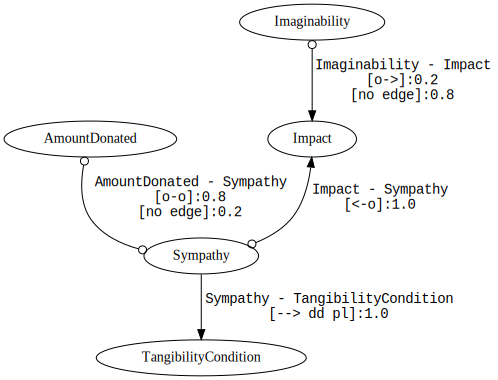

In [21]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [22]:
javabridge.detach()
javabridge.kill_vm()